# SPAC-seq Pipeline

This Protocol is for Stereo-seq based techniques.

Using this pipeline, you can perform:
1. Perform basic quanlity control with your CRISPR data, including:
   * Calculating perturbation guide correlation spatially
   * Calculating guide count and filter noises
2. Perform spatial awared clustering
   * Identify specific niche that can be later used to generate guide distribution
3. Perform PERMANOA analysis that identifies different distributed perturbation
   * Perturbed cells spatial distribution that significantly differ from references
   * Ranking of significance of cells

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import squidpy as sq
import scvi

import cellcharter as cc
from bin import utils

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python extension: {e}")
Global seed set to 0
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.simplefilter(action='ignore')

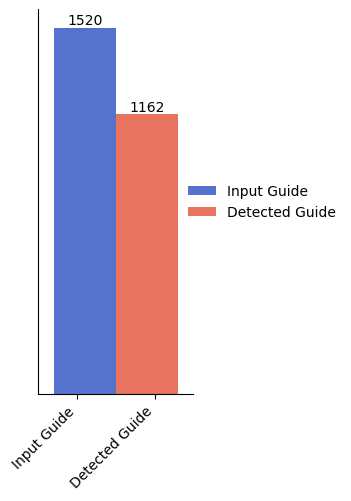

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Count': [1520, 1162],
    'Guide': ['Input Guide', 'Detected Guide']
})

plt.figure(figsize=(2, 5))
sns.barplot(y='Count', hue='Guide', data=df, palette=['royalblue', 'tomato'])
plt.legend(bbox_to_anchor=(2, 0.5), loc='right', frameon=False)
sns.despine(left=False, bottom=False)
plt.xticks([-0.25, 0.25], ['Input Guide', 'Detected Guide'], rotation=45, ha='right')
plt.yticks([])
plt.text(-0.2, 1520, '1520', ha='center', va='bottom')
plt.text(0.2, 1162, '1162', ha='center', va='bottom')
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/guide_count_stereo.pdf', bbox_inches='tight', format='pdf')
plt.show()


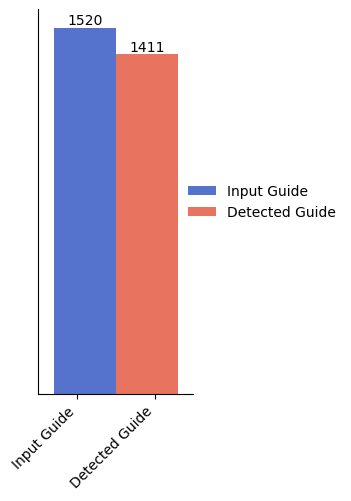

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame({
    'Count': [1520, 1411],
    'Guide': ['Input Guide', 'Detected Guide']
})

plt.figure(figsize=(2, 5))
sns.barplot(y='Count', hue='Guide', data=df, palette=['royalblue', 'tomato'])
plt.legend(bbox_to_anchor=(2, 0.5), loc='right', frameon=False)
sns.despine(left=False, bottom=False)
plt.xticks([-0.25, 0.25], ['Input Guide', 'Detected Guide'], rotation=45, ha='right')
plt.yticks([])
plt.text(-0.2, 1520, '1520', ha='center', va='bottom')
plt.text(0.2, 1411, '1411', ha='center', va='bottom')
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/guide_count_hd.pdf', bbox_inches='tight', format='pdf')
plt.show()


## Load Spatial Data

Before loading **CRISPR and TISSUE data**, make sure that your data are aligned, that is, the spatial coordinates in the samples are the same corresponding to the cell names. We here provide a in house script to perfrom alignment. However, we recommend merging data from top down to avoid bugs.

In [6]:
spatial_data = sc.read_h5ad("./RNA/B03502E5.combined.bin20.h5")

In [8]:
# guide_data = sc.read_h5ad("/home/wpy/stereoseq/20240802-Tumor/RNA/B03502E5.filtered.guide.fixed.bin100.h5")

Spatial data are then separated to TISSUE data and GUIDE data.

In [7]:
guide_data = spatial_data[:, spatial_data.var_names.str.startswith('sg')].copy()
guide_data

AnnData object with n_obs × n_vars = 382968 × 1161
    obsm: 'spatial'

In [9]:
pd.DataFrame(guide_data.X.toarray().sum(axis=0), columns=['count'], index=guide_data.var_names).to_csv('../20240802-Tumor/guide_count_stereo.csv')

In [5]:
rna_data = spatial_data[:, ~spatial_data.var_names.str.startswith('sg')].copy()
rna_data

AnnData object with n_obs × n_vars = 15551 × 22215
    obsm: 'spatial'

In [16]:
del spatial_data

# Plot Guide Distribution

In [26]:
plot_data = utils.combine_guide_replicates(guide_data)
plot_data = plot_data[:, plot_data.X.sum(axis=0) > 500].copy()
plot_data

AnnData object with n_obs × n_vars = 382968 × 194
    obsm: 'spatial'

In [28]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

n = len(plot_data.var_names)
colors = cm.turbo(np.linspace(0, 1, n))

plt.figure(figsize=(6, 6))
for i, guide in enumerate(plot_data.var_names):
    sns.scatterplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1],
                    s=plot_data[:, guide].X.flatten(),
                    label=guide, color=colors[i],
                    alpha=1, legend=False)
sns.despine(left=True, bottom=True)
plt.xticks([])
plt.yticks([])

plt.savefig('./plots/guide_distribution_500.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Tissue data QC

Not all genes in tissue data are we interested enough to analyze them. Here we perform **Housekeeping Gene** filter, and remove **Ribosome, Mitochondria** genes, together with genes that are irrelevent to tumor immune response: genes with **Rik** (LncRNA) and **Gm** (Germline).

In [41]:
filtered_rna_data = utils.remove_mito_ribo_hk_lnc_genes(rna_data)
filtered_rna_data

View of AnnData object with n_obs × n_vars = 15551 × 14295
    var: 'mt', 'mt-', 'gm', 'Rb', 'rik'
    obsm: 'spatial'

In [42]:
del filtered_rna_data.var

Spatial data are full of cells (bins) that have too few genes or counts, we here filter them out with a certain threshold.

In [43]:
sc.pp.calculate_qc_metrics(filtered_rna_data, inplace=True, log1p=False)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


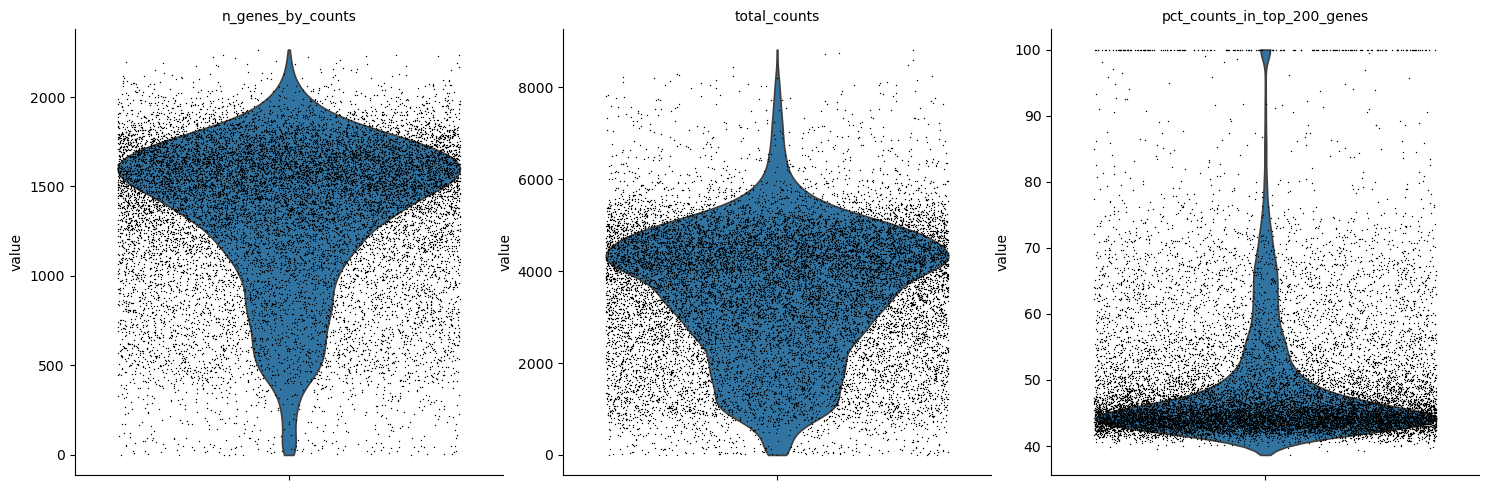

In [44]:
sc.pl.violin(filtered_rna_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_200_genes'], jitter=0.4, multi_panel=True)

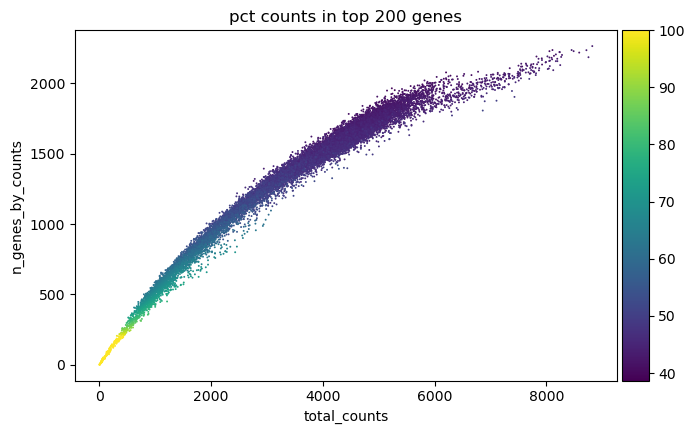

In [11]:
sc.pl.scatter(filtered_rna_data, 'total_counts', 'n_genes_by_counts', color='pct_counts_in_top_200_genes')

In [45]:
sc.pp.filter_cells(filtered_rna_data, min_genes=200)
sc.pp.filter_cells(filtered_rna_data, min_counts=500)
sc.pp.filter_genes(filtered_rna_data, min_cells=3)

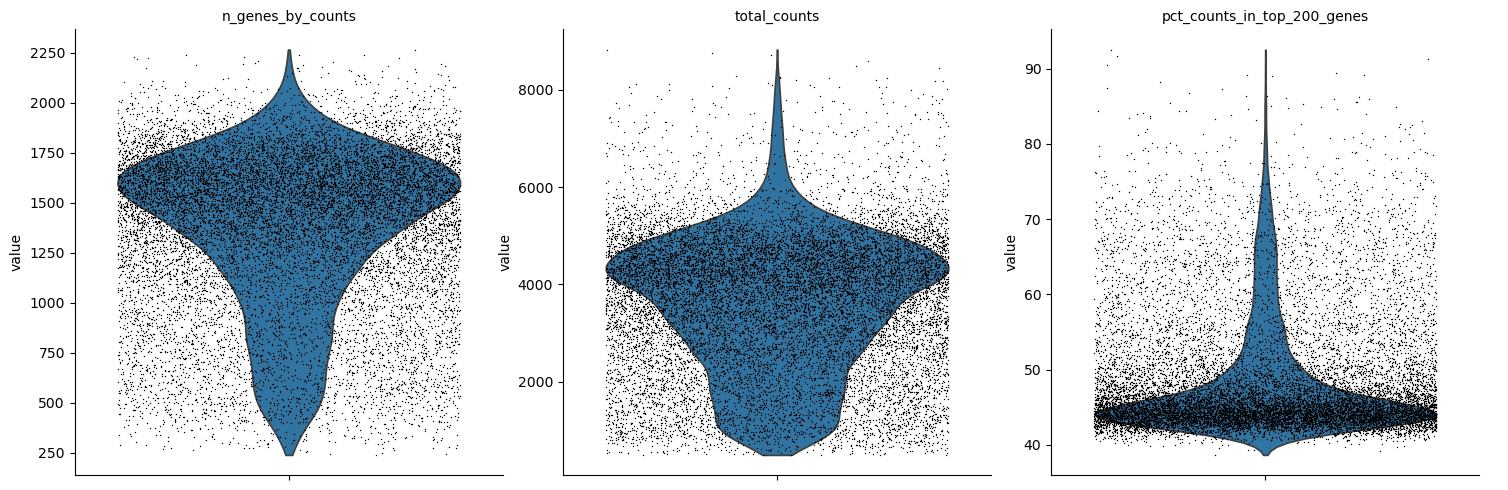

In [13]:
sc.pl.violin(filtered_rna_data, ['n_genes_by_counts', 'total_counts', 'pct_counts_in_top_200_genes'], jitter=0.4, multi_panel=True)

# Prepare for Clustering

We uses cellcharter to spatial awarely cluster cells (bins) in multiple panels. Before performing cellcharter, several preparations are to be made.

In [46]:
cluster_data = filtered_rna_data.copy()

We save the raw counts in new layer, and perform normalization and PCA.

In [47]:
cluster_data.layers["counts"] = cluster_data.X.copy()

In [48]:
sc.pp.normalize_total(cluster_data, target_sum=1e4)
sc.pp.log1p(cluster_data)

In [49]:
sc.tl.pca(cluster_data)

Then scVI is used to reduce batch effect between samples.

In [50]:
scvi.settings.seed = np.random.randint(1e4)

Global seed set to 2780


In [19]:
scvi.model.SCVI.setup_anndata(cluster_data)

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/scvi/data/fields/_layer_field.py:90: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  warnings.warn(


In [20]:
cluster_data.X = cluster_data.layers['counts'].copy()
model = scvi.model.SCVI(cluster_data, n_hidden=32, n_latent=10, n_layers=5, gene_likelihood="poisson", latent_distribution="normal")

Here note that scvi requires raw count data to perform reduction.

In [21]:
model.train(early_stopping=True, enable_progress_bar=True)

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(


Epoch 21/400:   5%|▌         | 20/400 [01:35<26:18,  4.15s/it, loss=5.45e+03, v_num=1]

/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
model.save("/home/wpy/stereoseq/20240802-Tumor/scvi.model", save_anndata=True, overwrite=True)

In [51]:
model = scvi.model.SCVI.load("/home/wpy/stereoseq/20240802-Tumor/scvi.model")

INFO     File /home/wpy/stereoseq/20240802-Tumor/scvi.model/model.pt already downloaded                            


In [52]:
cluster_data.obsm["X_scVI"] = model.get_latent_representation(cluster_data).astype(np.float32)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


We then finished the dimension reduction using scVI.

# Cellcharter Clustering

The purpose of the part is to identify specific spatial niche, that is the distribution of T cell's background.

In [53]:
sq.gr.spatial_neighbors(cluster_data, coord_type="generic", delaunay=True, spatial_key="spatial")

In [54]:
cc.gr.remove_long_links(cluster_data)
cc.gr.aggregate_neighbors(cluster_data, n_layers=3, use_rep="X_scVI", out_key="X_cellcharter")

100%|██████████| 4/4 [00:00<00:00, 51.31it/s]


In [ ]:
autok = cc.tl.ClusterAutoK(n_clusters = (5,15), max_runs = 5, model_params = dict(random_state = np.random.randint(1e6)))
autok.fit(cluster_data, use_rep="X_cellcharter")

Iteration 1/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:10,  1.19it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:01<00:07,  1.53it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 2/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:03,  3.74it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:03,  3.04it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 3/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:03,  3.28it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:04,  2.74it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 4/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:03,  3.43it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:03,  3.00it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

Iteration 5/5


  0%|          | 0/13 [00:00<?, ?it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
  8%|▊         | 1/13 [00:00<00:04,  2.49it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/wpy/miniconda3/envs/cellcharter/lib/python3.10 ...
  rank_zero_warn(
 15%|█▌        | 2/13 [00:00<00:04,  2.67it/s]/home/wpy/miniconda3/envs/cellcharter/lib/python3.10/site-packages/lightning_fabri

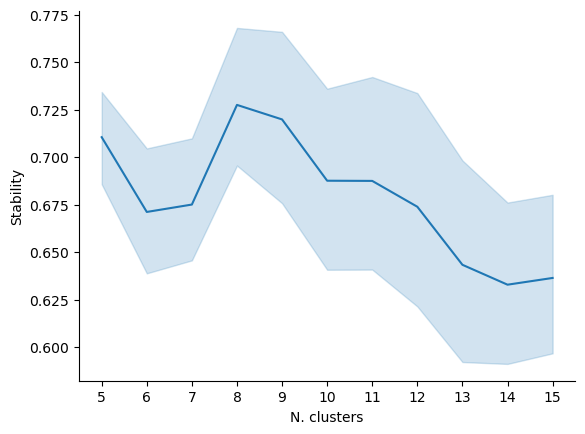

In [ ]:
cc.pl.autok_stability(autok)

In [ ]:
cluster_data.obs["cluster"] = autok.predict(cluster_data, use_rep="X_cellcharter")

In [55]:
givenk = cc.tl.Cluster(n_clusters=8)
givenk.fit(cluster_data, use_rep="X_cellcharter")
cluster_data.obs["cluster"] = givenk.predict(cluster_data, use_rep="X_cellcharter")

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 181.38it/s]


Cellcharter provide us the appropriate cluster between multisamples after stability test.

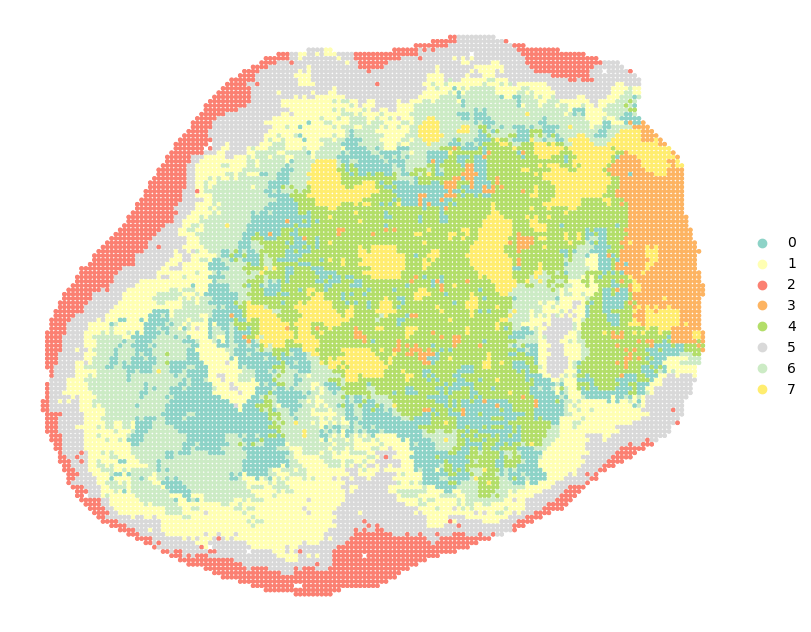

In [290]:
sq.pl.spatial_scatter(cluster_data,
    color=['cluster'], size=20, img=None,
    spatial_key='spatial', palette='Set3', figsize=(8,8), ncols=2, shape=None)
sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.show()

Then we can use spatial cluster results to identify spatially niche with specific process or interaction.

In [ ]:
# sc.pp.normalize_total(cluster_data, target_sum=1e4)
# sc.pp.log1p(cluster_data)

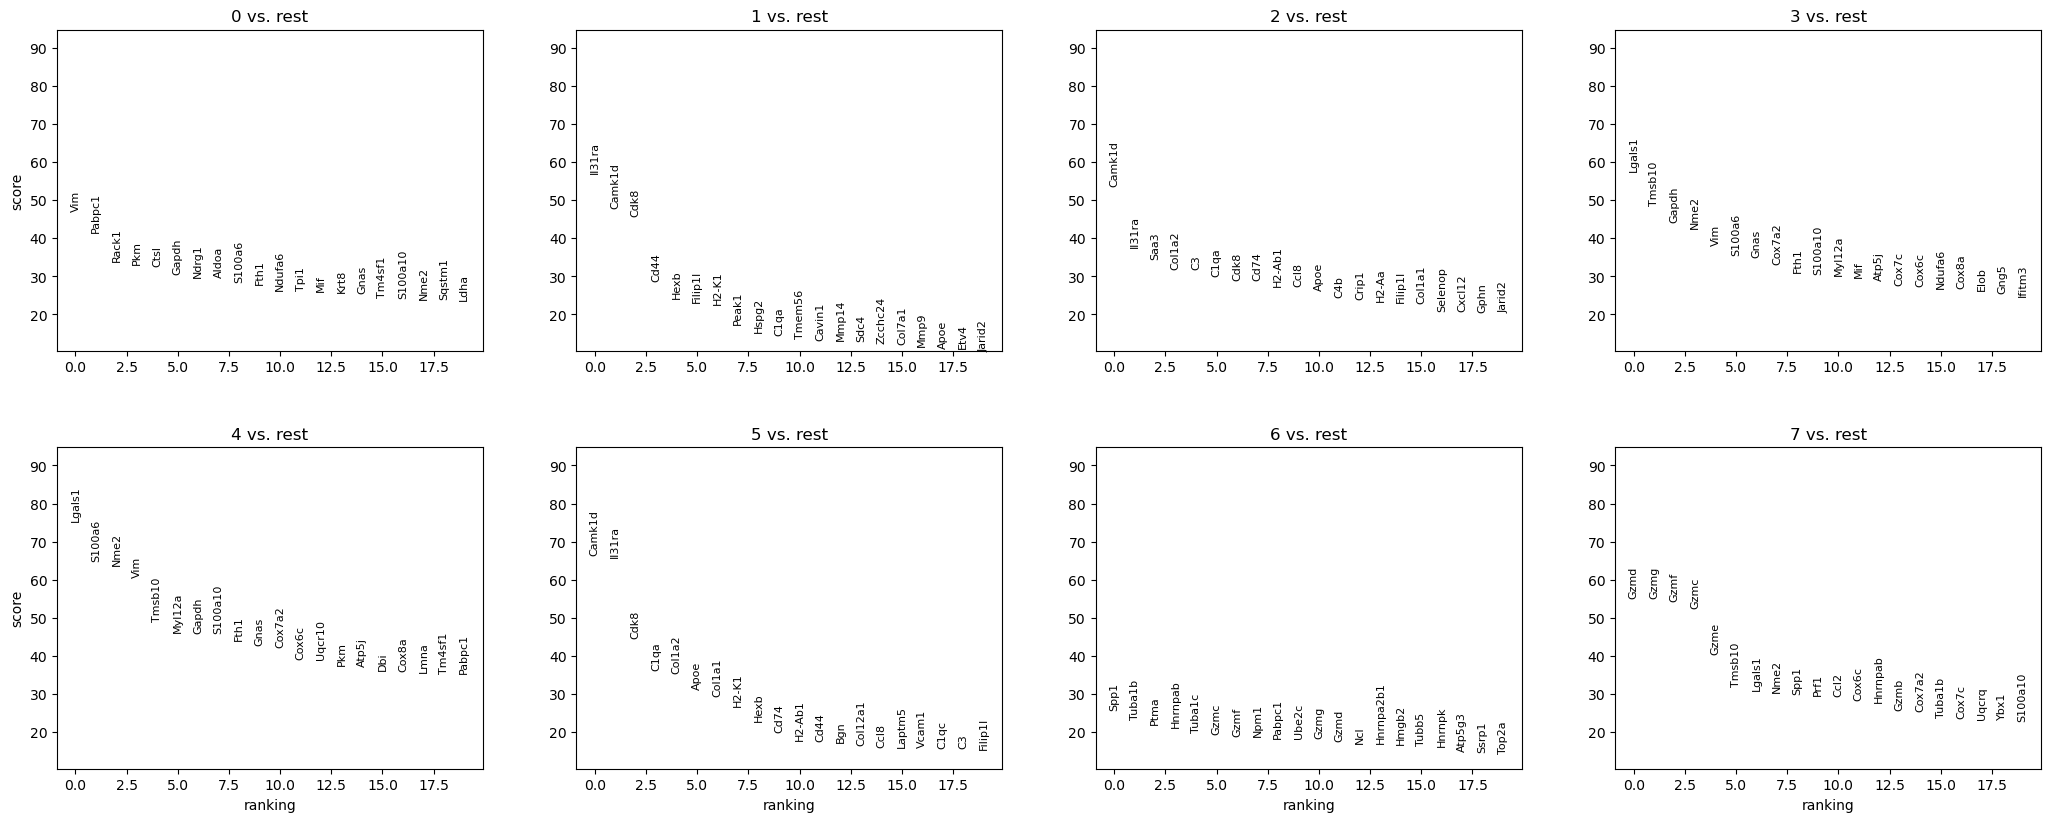

In [292]:
sc.tl.rank_genes_groups(cluster_data, method='t-test', groupby='cluster')
sc.pl.rank_genes_groups(cluster_data)

In [300]:
cluster_data

AnnData object with n_obs × n_vars = 15313 × 12850
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes', 'n_counts', '_scvi_batch', '_scvi_labels', 'cluster', 'coord_x', 'coord_y'
    uns: 'cluster_colors', 'rank_genes_groups', 'dendrogram_cluster'
    obsm: 'spatial', 'X_pca', 'X_scVI', 'X_cellcharter'
    layers: 'counts'

In [299]:
cluster_data.obs['cluster'] = cluster_data.obs['cluster'].astype('category')
sc.pl.rank_genes_groups_dotplot(cluster_data, n_genes=10)

TypeError: sequence item 0: expected str instance, int found

In [57]:
cluster_data.write_h5ad('/home/wpy/stereoseq/20240802-Tumor/RNA/B03502E5.clustered.h5')

# Spatial Correlation

If the perturbation of each gene is elucidated by multiple guide, we would expect that perturbation is effective if **multiple guide distribution** similarly in different clusters, then demonstrating that they correspondingly changes cell behaviour through distribution.

In [20]:
# cluster_data = sc.read_h5ad('/home/wpy/stereoseq/20240802-Tumor/RNA/B03502E5.clustered.h5')
spatial_data = sc.read_h5ad("./RNA/B03502E5.combined.bin100.h5")
guide_data = spatial_data[:, spatial_data.var_names.str.startswith('sg')].copy()

In [21]:
mag_genes = ["Mki67", "Epcam", "Top2a", "Ascl2", "Cbx3", "Hsp90ab1", "Zfas1", "Pabpc1", "Gtf3a", "Nap1l1", "Tgfbi", "Ifitm3", "Hspd1", "Nono", "Hsph1", "Nkd1", "Ly6e", "C6orf48", "Ssb", "Rsl1d1", "Dpep1", "Dkc1", "Bmp4", "Gng4", "Cpne1", "Zdhhc9", "Dars", "Scd", "Myc", "Phlda1", "Dach1", "Cldn1", "Krt23"]
mag_genes = np.intersect1d(mag_genes, cluster_data.var_names)

In [22]:
spatial_data.obsm['spatial']

array([[ 9249,  1649],
       [12349,  2449],
       [ 6549,  2649],
       ...,
       [ 1350, 11349],
       [ 7249,   349],
       [12849,   449]])

In [25]:
11068 / (11068 + 33)

0.9970272948383029

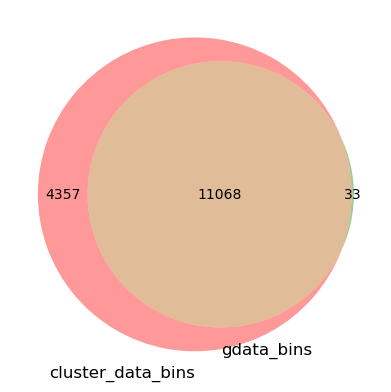

In [23]:
cluster_data_bins = spatial_data[spatial_data[:, mag_genes].X.toarray().sum(axis=1) > 0, :].obs_names.tolist()
gdata_bins = guide_data[guide_data[:, guide_data.var_names.str.startswith('sg')].X.toarray().sum(axis=1) > 0, :].obs_names.tolist()
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

venn2([set(cluster_data_bins), set(gdata_bins)], ('cluster_data_bins', 'gdata_bins'))

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('./plots/venn.pdf', dpi=300, bbox_inches='tight', format='pdf')
plt.show()

In [7]:
cluster_data.obs['coord_x'] = cluster_data.obsm['spatial'][:, 0] // 100 * 100
cluster_data.obs['coord_y'] = cluster_data.obsm['spatial'][:, 1] // 100 * 100
guide_data.obs['coord_x'] = guide_data.obsm['spatial'][:, 0] // 100 * 100
guide_data.obs['coord_y'] = guide_data.obsm['spatial'][:, 1] // 100 * 100
cluster_data.obs_names = [str(x) + '_' + str(y) for x, y in zip(cluster_data.obs['coord_x'], cluster_data.obs['coord_y'])]
guide_data.obs_names = [str(x) + '_' + str(y) for x, y in zip(guide_data.obs['coord_x'], guide_data.obs['coord_y'])]
common_bins = np.intersect1d(cluster_data.obs_names, guide_data.obs_names)
cluster_data = cluster_data[common_bins].copy()
guide_data = guide_data[common_bins, :].copy()

In [8]:
del cluster_data.var
del cluster_data.uns
del cluster_data.varm
del cluster_data.obsp

Since TISSUE data has been filtered with plenty of cells, we need to align them with GUIDE data.

In [9]:
guide_data = guide_data[cluster_data.obs_names, :].copy()

We calculate the proportion correlation of multiple guide in each cluster for one gene, as to compare perturbation quality.

In [10]:
guide_data = utils.combine_guide_replicates(guide_data)

In [11]:
c_df = pd.concat([pd.DataFrame(guide_data.X, columns=guide_data.var_names, index=guide_data.obs_names), cluster_data.obs["cluster"]], axis=1)
c_df = c_df.groupby('cluster').sum()
c_df = c_df.div(c_df.sum(axis=0))
c_df

sgAbca2   sgAbca7  sgAbcb1b   sgAbcc1  sgAbcc10   sgAbcc3   sgAbcc4  \
cluster                                                                         
0        0.162963  0.166891  0.180791  0.154648  0.175824  0.165289  0.149184   
1        0.037037  0.045760  0.039548  0.046916  0.016484  0.049587  0.037296   
2        0.003704  0.012113  0.005650  0.006082  0.000000  0.000000  0.006993   
3        0.385185  0.351279  0.389831  0.350130  0.274725  0.388430  0.296037   
4        0.177778  0.196501  0.158192  0.206777  0.252747  0.190083  0.193473   
5        0.011111  0.020188  0.016949  0.023458  0.010989  0.016529  0.013986   
6        0.100000  0.088829  0.084746  0.107732  0.071429  0.049587  0.160839   
7        0.122222  0.118439  0.124294  0.104257  0.197802  0.140496  0.142191   

          sgAbcc5   sgAbhd2    sgAbi1  ...   sgVsig2    sgWwp1    sgYbx1  \
cluster                                ...                                 
0        0.149254  0.155105  0.149470  ...  0.167339  0.178571  0.239382   
1        0.047264  0.054560  0.047252  ...  0.028226  0.089286  0.058880   
2        0.017413  0.016368  0.005786  ...  0.006048  0.000000  0.011583   
3        0.333333  0.298519  0.381871  ...  0.310484  0.348214  0.281853   
4        0.194030  0.218239  0.195757  ...  0.245968  0.133929  0.188224   
5        0.014925  0.029618  0.022179  ...  0.014113  0.000000  0.032819   
6        0.166667  0.117693  0.089682  ...  0.094758  0.098214  0.087838   
7        0.077114  0.109899  0.108004  ...  0.133065  0.151786  0.099421   

           sgYbx3    sgYes1  sgZdhhc20  sgZdhhc4  sgZfp664  sgZfyve27  \
cluster                                                                 
0        0.177966  0.185792   0.171667  0.101266  0.138743   0.095238   
1        0.042373  0.043716   0.033333  0.000000  0.041885   0.095238   
2        0.000000  0.000000   0.001667  0.025316  0.007853   0.000000   
3        0.367232  0.377049   0.363333  0.392405  0.329843   0.285714   
4        0.186441  0.158470   0.186667  0.164557  0.246073   0.285714   
5        0.028249  0.000000   0.011667  0.000000  0.015707   0.000000   
6        0.087571  0.065574   0.110000  0.101266  0.117801   0.047619   
7        0.110169  0.169399   0.121667  0.215190  0.102094   0.190476   

            sgZp3  
cluster            
0        0.186010  
1        0.036566  
2        0.001590  
3        0.317965  
4        0.238474  
5        0.007949  
6        0.090620  
7        0.120827  

[8 rows x 687 columns]

In [12]:
from scipy.stats import spearmanr
from tqdm import tqdm

guide_names = c_df.columns.str.split('_').str.get(0)
correlation_between_guides = {}
for guide_name in tqdm(guide_names):
    guide_1 = guide_name + "_1_gene"
    guide_2 = guide_name + "_2_gene"
    if guide_1 in c_df.columns and guide_2 in c_df.columns:
        correlation_between_guides[guide_name] = spearmanr(c_df[guide_1], c_df[guide_2])[0]
    else:
        correlation_between_guides[guide_name] = 0
p_df = pd.DataFrame(correlation_between_guides, index=['spearmanr']).T

100%|██████████| 687/687 [00:00<00:00, 146223.83it/s]

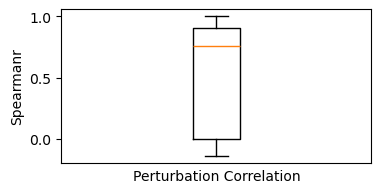

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 2))
plt.boxplot(p_df['spearmanr'])
plt.xticks([])
plt.xlabel('Perturbation Correlation')
plt.ylabel('Spearmanr')
plt.show()

# Proportion ANOVA

If we want a general look into which guide differs from control, we perfromed anova in proportion distribution of guide and Non-targeting.

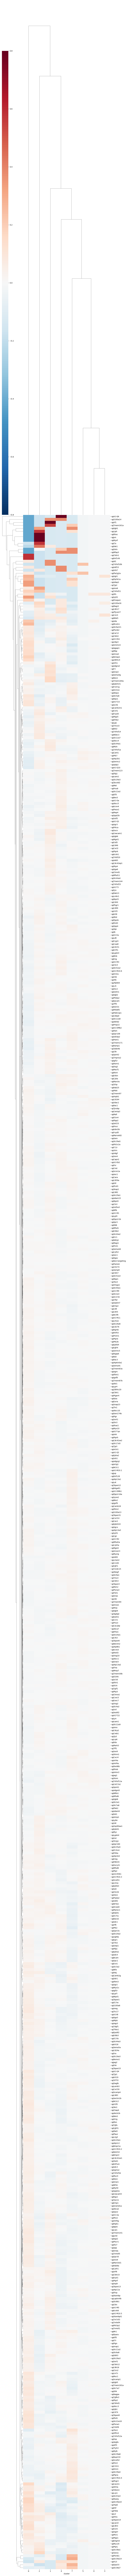

In [50]:
import seaborn as sns

perturb_data = utils.combine_guide_replicates(guide_data)
c_df = pd.concat([pd.DataFrame(perturb_data.X, columns=perturb_data.var_names, index=perturb_data.obs_names), cluster_data.obs["cluster"]], axis=1)
c_df = c_df.groupby('cluster').sum()
c_df = c_df.div(c_df.sum(axis=0))
sns.clustermap(c_df.T - (c_df['sgNon-targeting']), figsize=(10, 200), cmap='RdBu_r', vmax=0.8, vmin=-0.8)

In [31]:
perturb_data = utils.combine_guide_replicates(guide_data)
c_df = pd.concat([pd.DataFrame(perturb_data.X, columns=perturb_data.var_names, index=perturb_data.obs_names), cluster_data.obs["cluster"]], axis=1)
c_df = c_df.groupby('cluster').sum()

In [33]:
from scipy.stats import chi2_contingency
chi_p = {}
for guide in tqdm(c_df.columns):
    observed = np.array([c_df['sgNon-targeting'].tolist(), c_df[guide].tolist()])
    chi_p[guide] = chi2_contingency(observed)[1]

100%|██████████| 687/687 [00:00<00:00, 2760.63it/s]


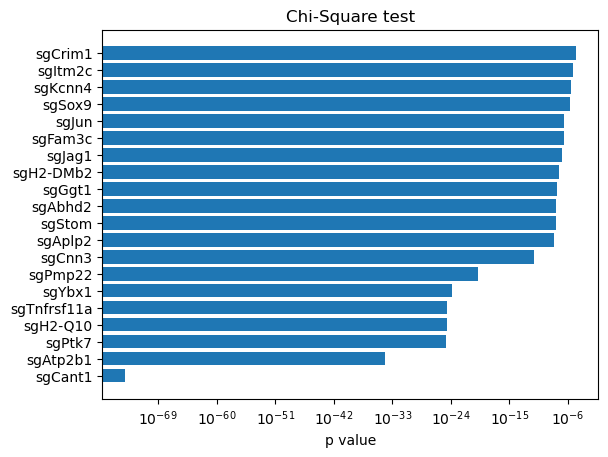

In [46]:
chi_df = pd.DataFrame(chi_p, index=['chi_p']).T.sort_values(by='chi_p')
plt.barh(chi_df.iloc[:20].index, chi_df.iloc[:20].chi_p)
plt.gca().set_xscale('log')
plt.title('Chi-Square test')
plt.xlabel('p value')
plt.show()

In [47]:
from scipy.special import rel_entr
kl_div = {}
for guide in tqdm(c_df.columns):
    observed = rel_entr(c_df['sgNon-targeting'].tolist(), c_df[guide].tolist())
    kl_div[guide] = np.sum(observed)

100%|██████████| 687/687 [00:00<00:00, 13262.42it/s]


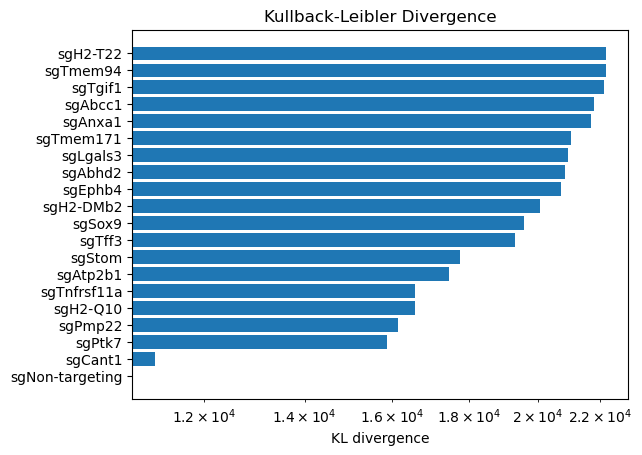

In [48]:
chi_df = pd.DataFrame(kl_div, index=['kl_div']).T.sort_values(by='kl_div')
plt.barh(chi_df.iloc[:20].index, chi_df.iloc[:20].kl_div)
plt.gca().set_xscale('log')
plt.title('Kullback-Leibler Divergence')
plt.xlabel('KL divergence')
plt.show()

Text(0.5, 0, 'KL divergence')

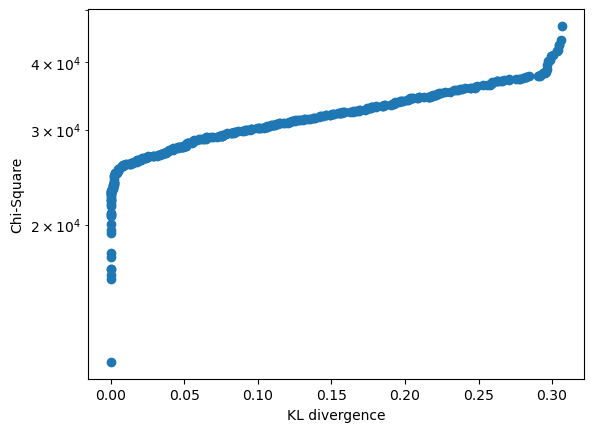

In [53]:
chi_df = pd.DataFrame(chi_p, index=['chi_p']).T.sort_values(by='chi_p')
kld_df = pd.DataFrame(kl_div, index=['kl_div']).T.sort_values(by='kl_div')

plt.scatter(chi_df, kld_df)
plt.gca().set_yscale('log')
plt.ylabel('Chi-Square')
plt.xlabel('KL divergence')

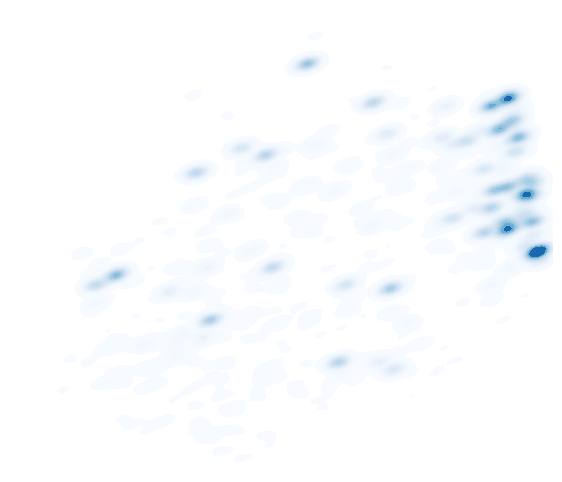

In [269]:
plot_data = guide_data
plt.figure(figsize=((plot_data.obsm['spatial'][:, 0].max() - plot_data.obsm['spatial'][:, 0].min()) // 2000,
                     (plot_data.obsm['spatial'][:, 1].max() - plot_data.obsm['spatial'][:, 1].min()) // 2000))
sns.kdeplot(x=plot_data.obsm['spatial'][:, 0], y=plot_data.obsm['spatial'][:, 1], weights=np.array(plot_data.X.sum(axis=1)).flatten(),
            fill=True, bw_adjust=0.1, alpha=1, levels=20, legend=False, cmap='Blues')

sns.despine(left=True, bottom=True)
plt.xlabel('')
plt.ylabel('')
plt.title('')
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])

plt.rcParams['pdf.fonttype']=42
plt.savefig("./plots/guide_kde.pdf", format="pdf", bbox_inches='tight')
plt.show()

StopIteration: 

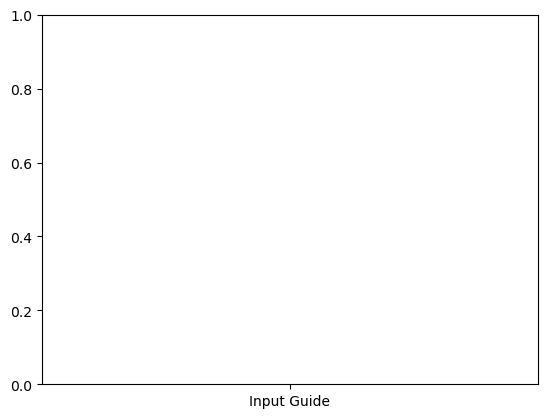

In [270]:
sns.barplot(x=['Input Guide', 'Detected Guide'], y=[1520, 1106])

# PERMANOVA

In [38]:
from skbio.stats.distance import permanova, DistanceMatrix
from scipy.spatial.distance import pdist, squareform

In [225]:
guide_data.obs['cluster'] = cluster_data.obs['cluster']

In [226]:
c_df = pd.concat([pd.DataFrame(guide_data.X, columns=guide_data.var_names, index=guide_data.obs_names), guide_data.obs["cluster"]], axis=1)

In [238]:
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

p_value = {}
f_value = {}
for guide in tqdm(c_df.columns):
    if guide == "sgNon-targeting": continue
    g_df = c_df[[guide, "sgNon-targeting", "cluster"]]

    masks = {c: (g_df.cluster == c) for c in g_df.cluster.unique()}
    df = pd.DataFrame(columns=range(100))

    guide_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', guide]).count().unstack()['sgNon-targeting']], axis=0).fillna(0))
    ntc_cnts = np.array(pd.concat([df, g_df.groupby(['cluster', 'sgNon-targeting']).count().unstack()[guide]], axis=0).fillna(0))
    data = np.vstack([guide_cnts, ntc_cnts])
    sample_ids = np.array([[name + str(c) for c in g_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()

    dist_matrix = squareform(pdist(data, metric='braycurtis'))
    metadata = pd.DataFrame({
        'group': ['A'] * 8 + ['B'] * 8
    }, index=sample_ids)
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=200)
    p_value[guide] = results['p-value']

100%|█████████▉| 687/688 [16:43<00:01,  1.46s/it]


AttributeError: 'DataFrame' object has no attribute 'unique'

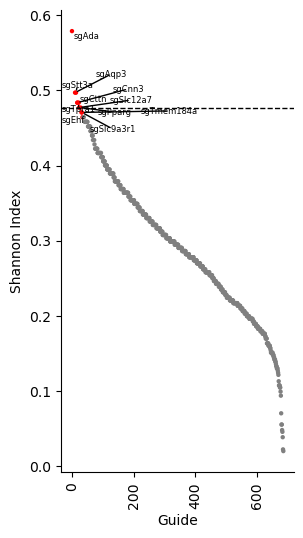

In [240]:
import seaborn as sns
import matplotlib.pyplot as plt

p_df = pd.DataFrame(p_value.values(), index=p_value.keys())
p_df.sort_values(by=0, ascending=True, inplace=True)
p_df['p'] = -np.log10(p_df[0])
p_df['rank'] = np.arange(len(p_df))
p_df.dropna(inplace=True)
p_df = p_df.loc[guide_data.var_names[(guide_data.X.sum(axis=0) > 5) & (guide_data.var_names != 'sgNon-targeting')], :]
p_df['sig'] = p_df['rank'].map(lambda x: 'yes' if x <= np.quantile(p_df['rank'], 0.016) else 'no')

plt.figure(figsize=(3, 6))
sns.scatterplot(x='rank', y='p', data=p_df, color='black', s=10, hue='sig', palette=['gray', 'red'], legend=False, edgecolor='none')
plt.axhline(y=p_df['p'].quantile(0.99), color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
texts = []
cnt = 0
for i, row in p_df.iterrows():
    if row['sig'] == 'yes':
        texts.append(plt.text(row['rank'], row['p'], i, fontsize=6, alpha=1, ha='center', va='top', rotation=0))
        # plt.vlines(x=row['rank'], ymin=row['Shannon'] + cnt * 0.04, ymax=row['Shannon'], color='black', linewidth=0.5, linestyle='-', alpha=1)
        cnt += 1
import adjustText as aT
aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(2, 2), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))
plt.xlabel('Guide')
plt.xticks(rotation=90)
plt.ylabel('Shannon Index')
sns.despine()

# plt.ylim(-0.2, 1.2)

plt.rcParams['pdf.fonttype'] = 42
plt.savefig('/home/wpy/stereoseq/20240802-Tumor/plots/permanova_guide.pdf', bbox_inches='tight', format='pdf')
plt.show()

# Shannon Index

We calculate Shannon Index for each guide.

In [11]:
from scipy.stats import entropy

In [12]:
# qk_guide = guide_data[:, 'sgNon-targeting'].X.sum(axis=1).flatten() / guide_data[:, 'sgNon-targeting'].X.sum()
qk_guide = guide_data.X.sum(axis=1).flatten() / guide_data.X.sum()
entro = {}
for guide in guide_data.var_names:
    if guide_data[:, guide].X.sum() < 10: continue
    pk_guide = guide_data[:, guide].X.flatten() / guide_data[:, guide].X.sum()
    entro[guide] = entropy(pk_guide, qk_guide)

Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


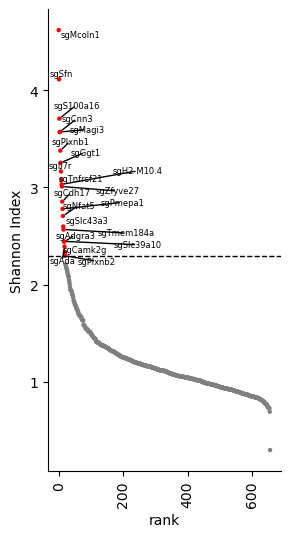

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

entro_df = pd.DataFrame(entro.values(), index=entro.keys())
# p_df = p_df.loc[guide_data.var_names[guide_data.X.sum(axis=0) > 0], :]
entro_df.sort_values(by=0, ascending=False, inplace=True)
entro_df['Shannon'] = entro_df[0]
entro_df.dropna(inplace=True)
entro_df['rank'] = np.arange(len(entro_df))
entro_df['sig'] = entro_df['rank'].map(lambda x: 'yes' if x <= 20 else 'no')

plt.figure(figsize=(3, 6))
sns.scatterplot(x='rank', y='Shannon', data=entro_df, color='black', s=10, hue='sig', palette=['red', 'gray'], legend=False, edgecolor='none')
plt.axhline(y=entro_df['Shannon'].iloc[20], color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
texts = []
cnt = 0
for i, row in entro_df.iterrows():
    if row['sig'] == 'yes':
        texts.append(plt.text(row['rank'], row['Shannon'], i, fontsize=6, alpha=1, ha='center', va='top', rotation=0))
        # plt.vlines(x=row['rank'], ymin=row['Shannon'] + cnt * 0.04, ymax=row['Shannon'], color='black', linewidth=0.5, linestyle='-', alpha=1)
        cnt += 1
import adjustText as aT
aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))
plt.xlabel('rank')
plt.xticks(rotation=90)
plt.ylabel('Shannon Index')
sns.despine()

# plt.ylim(-0.2, 1.2)

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('/home/wpy/stereoseq/20240802-Tumor/plots/shannon_guide.pdf', bbox_inches='tight', format='pdf')
plt.show()

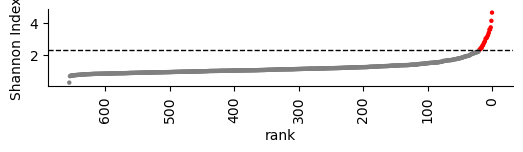

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

entro_df = pd.DataFrame(entro.values(), index=entro.keys())
# p_df = p_df.loc[guide_data.var_names[guide_data.X.sum(axis=0) > 0], :]
entro_df.sort_values(by=0, ascending=False, inplace=True)
entro_df['Shannon'] = entro_df[0]
entro_df.dropna(inplace=True)
entro_df['rank'] = np.arange(len(entro_df))
entro_df['sig'] = entro_df['rank'].map(lambda x: 'yes' if x <= 20 else 'no')

plt.figure(figsize=(6, 1))
sns.scatterplot(x='rank', y='Shannon', data=entro_df, color='black', s=10, hue='sig', palette=['red', 'gray'], legend=False, edgecolor='none')
plt.axhline(y=entro_df['Shannon'].iloc[20], color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
# texts = []
# cnt = 0
# for i, row in entro_df.iterrows():
    # if row['sig'] == 'yes':
        # texts.append(plt.text(row['rank'], row['Shannon'], i, fontsize=6, alpha=1, ha='center', va='top', rotation=0))
        # plt.vlines(x=row['rank'], ymin=row['Shannon'] + cnt * 0.04, ymax=row['Shannon'], color='black', linewidth=0.5, linestyle='-', alpha=1)
        # cnt += 1
# import adjustText as aT
# aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))
plt.xlabel('rank')
plt.xticks(rotation=90)
plt.ylabel('Shannon Index')
sns.despine()

plt.gca().invert_xaxis()
# plt.ylim(-0.2, 1.2)

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('/home/wpy/stereoseq/20240802-Tumor/plots/shannon_guide.pdf', bbox_inches='tight', format='pdf')
plt.show()

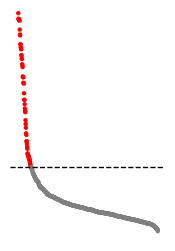

In [243]:
import seaborn as sns
import matplotlib.pyplot as plt

entro_df = pd.DataFrame(entro.values(), index=entro.keys())
# p_df = p_df.loc[guide_data.var_names[guide_data.X.sum(axis=0) > 0], :]
entro_df.sort_values(by=0, ascending=False, inplace=True)
entro_df['Shannon'] = entro_df[0]
entro_df.dropna(inplace=True)
entro_df['rank'] = np.arange(len(entro_df))
entro_df['sig'] = entro_df['rank'].map(lambda x: 'yes' if x <= np.quantile(entro_df['rank'], 0.1) else 'no')

plt.figure(figsize=(2, 3))
sns.scatterplot(x='rank', y='Shannon', data=entro_df, color='black', s=10, hue='sig', palette=['red', 'gray'], legend=False, edgecolor='none')
plt.axhline(y=entro_df['Shannon'].quantile(0.9), color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
# texts = []
# cnt = 0
# for i, row in entro_df.iterrows():
    # if row['sig'] == 'yes':
        # texts.append(plt.text(row['rank'], row['Shannon'], i, fontsize=6, alpha=1, ha='center', va='top', rotation=0))
        # plt.vlines(x=row['rank'], ymin=row['Shannon'] + cnt * 0.04, ymax=row['Shannon'], color='black', linewidth=0.5, linestyle='-', alpha=1)
        # cnt += 1
# import adjustText as aT
# aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))
# plt.xlabel('rank')
# plt.xticks(rotation=90)
# plt.ylabel('Shannon Index')
plt.ylabel('')
plt.xlabel('')
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

plt.ylim([0.5, 5])

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('/home/wpy/stereoseq/20240802-Tumor/plots/shannon_guide.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [ ]:
p_df['gene'] = p_df.index.str.split('_').str.get(0)
np.multiply(p_df.groupby('gene')['rank'].std(), p_df.groupby('gene')['rank'].mean()).sort_values(ascending=True).head(20)

# Chi-square test

In [15]:
guide_data.obs['cluster'] = cluster_data.obs['cluster']
c_df = pd.concat([pd.DataFrame(guide_data.X, columns=guide_data.var_names, index=guide_data.obs_names), guide_data.obs["cluster"]], axis=1)
c_df = c_df.groupby('cluster').sum()
c_df = c_df.div(c_df.sum(axis=0)) * 100

In [16]:
from scipy.stats import chi2_contingency
from tqdm import tqdm
chi_p = {}
for guide in tqdm(c_df.columns):
    if guide_data[:, guide].X.sum() < 10: continue
    observed = np.array([c_df.sum(axis=1).tolist(), c_df[guide].tolist()]).T
    chi_p[guide] = chi2_contingency(observed)[1]

  0%|          | 0/687 [00:00<?, ?it/s]

100%|██████████| 687/687 [00:01<00:00, 459.79it/s]


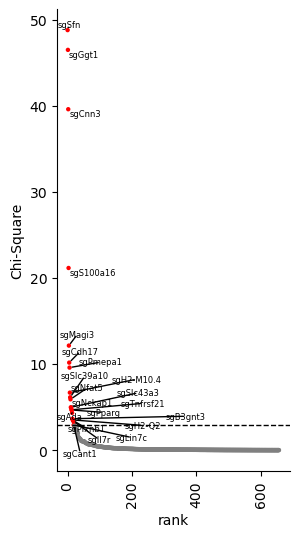

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

chi_df = pd.DataFrame(chi_p.values(), index=chi_p.keys())
# p_df = p_df.loc[guide_data.var_names[guide_data.X.sum(axis=0) > 0], :]
chi_df.sort_values(by=0, ascending=True, inplace=True)
chi_df['chi_p'] = -np.log10(chi_df[0])
chi_df.dropna(inplace=True)
chi_df['rank'] = np.arange(len(chi_df))
chi_df['sig'] = chi_df['rank'].map(lambda x: 'yes' if x <= 20 else 'no')

plt.figure(figsize=(3, 6))
sns.scatterplot(x='rank', y='chi_p', data=chi_df, color='black', s=10, hue='sig', palette=['red', 'gray'], legend=False, edgecolor='none')
plt.axhline(y=chi_df['chi_p'].iloc[20], color='black', linewidth=1, linestyle='--', alpha=1)
# plt.title('PERMANOVA between clusters-Count')
texts = []
cnt = 0
for i, row in chi_df.iterrows():
    if row['sig'] == 'yes':
        texts.append(plt.text(row['rank'], row['chi_p'], i, fontsize=6, alpha=1, ha='center', va='top', rotation=0))
        # plt.vlines(x=row['rank'], ymin=row['chi_p'] + cnt * 0.04, ymax=row['chi_p'], color='black', linewidth=0.5, linestyle='-', alpha=1)
        cnt += 1
import adjustText as aT
aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))
plt.xlabel('rank')
plt.xticks(rotation=90)
plt.ylabel('Chi-Square')
sns.despine()

# plt.ylim(-0.2, 1.2)

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('/home/wpy/stereoseq/20240802-Tumor/plots/chisquare_guide.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [35]:
guide_data.var_names[(guide_data.X.sum(axis=0) > 100) & guide_data.var_names.isin(np.intersect1d(shannon_top, chi_top))]

Index(['sgPtpra'], dtype='object')

In [ ]:
p_df['gene'] = p_df.index.str.split('_').str.get(0)
np.multiply(p_df.groupby('gene')['rank'].std(), p_df.groupby('gene')['rank'].mean()).sort_values(ascending=True).head(20)

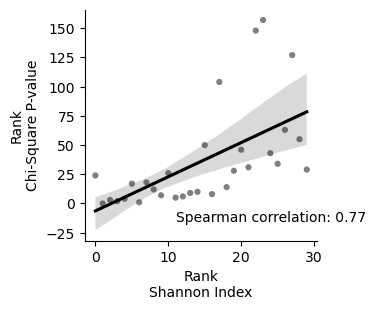

In [68]:
from scipy.stats import spearmanr

d_df = pd.concat([entro_df, chi_df], axis=1)
d_df.columns = ['Shannon', 'Shannon_1', 'rank_shannon', 'sig_shannon', 'Chi-Square', 'Chi-Square_1', 'rank_chisquare', 'sig_chisquare']
d_df = d_df.sort_values(by='rank_shannon').head(30)

plt.figure(figsize=(3, 3))

sns.scatterplot(x='rank_shannon', y='rank_chisquare', data=d_df, color=['gray'], s=20, edgecolor='none')
sns.regplot(x='rank_shannon', y='rank_chisquare', data=d_df, color='black', scatter=False)

# 计算Spearman相关系数
corr, _ = spearmanr(d_df['rank_shannon'], d_df['rank_chisquare'])
plt.text(0.8, 0.1, f'Spearman correlation: {corr:.2f}', ha='center', va='center', transform=plt.gca().transAxes)

# texts = []
# for i, row in d_df.iterrows():
    # if row['rank_shannon'] < 10:
        # texts.append(plt.text(row['rank_shannon'], row['rank_chisquare'], row.name, fontsize=6, alpha=1, ha='center', va='top', rotation=0))

# import adjustText as aT
# aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca(), arrowprops=dict(arrowstyle='-', color='black', lw=1))

plt.xlabel('Rank\nShannon Index')
plt.ylabel('Rank\nChi-Square P-value')
sns.despine()
plt.show()

In [51]:
venn_diagram.get_label_by_id('11')

Text(0.0, 2.9843758745317854e-17, '33')

共有的基因: {'sgNfat5', 'sgZfyve27', 'sgNckap1', 'sgTspan8', 'sgTuba1c', 'sgSlc43a3', 'sgH2-Q2', 'sgAnxa2', 'sgPmepa1', 'sgLsr', 'sgCnn3', 'sgTgfbr2', 'sgSfn', 'sgCamk2g', 'sgPlxnb1', 'sgMbp', 'sgMcoln1', 'sgAda', 'sgPlxnb2', 'sgTnfrsf21', 'sgCar12', 'sgMagi3', 'sgSlc39a10', 'sgTpra1', 'sgPtpra', 'sgPparg', 'sgSmim22', 'sgLcp1', 'sgGgt1', 'sgIl7r', 'sgH2-M10.4', 'sgCdh17', 'sgS100a16'}


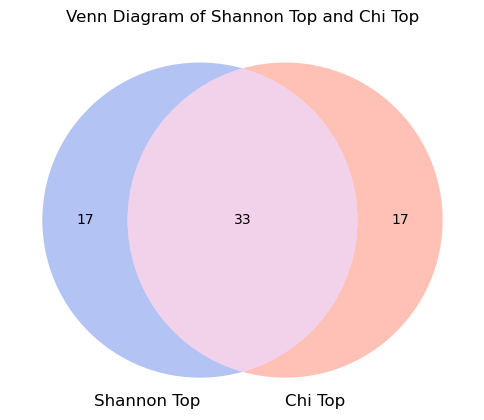

In [50]:
from matplotlib_venn import venn2

shannon_top = entro_df.sort_values(by='rank', ascending=True).head(50).index
chi_top = chi_df.sort_values(by='rank', ascending=True).head(50).index

# 转换为集合
set1 = set(shannon_top)
set2 = set(chi_top)

# 找到共有的基因
common_genes = set1.intersection(set2)
print("共有的基因:", common_genes)

# 绘制Venn图
plt.figure(figsize=(6, 6))
venn_diagram = venn2([set1, set2], ('Shannon Top', 'Chi Top'), 
                      set_colors=('royalblue', 'tomato'))  # 修改韦恩图颜色

# # 添加基因名字的注释
# texts = []
# for idx, gene in enumerate(common_genes):
#     texts.append(plt.annotate(gene, xy=venn_diagram.get_label_by_id('11').get_position() + np.array([0, 0.25-idx * 0.02]), 
#                  fontsize=7, ha='center'))

# for idx, gene in enumerate(set1 - common_genes):
#     texts.append(plt.annotate(gene, xy=venn_diagram.get_label_by_id('10').get_position() + np.array([0, 0.25-idx * 0.02]), 
#                  fontsize=7, ha='center'))
    
# for idx, gene in enumerate(set2 - common_genes):
#     texts.append(plt.annotate(gene, xy=venn_diagram.get_label_by_id('01').get_position() + np.array([0, 0.25-idx * 0.02]), 
#                  fontsize=7, ha='center'))
    
# import adjustText as aT
# aT.adjust_text(texts=texts, expand_points=(0, 0), expand_text=(0, 0), ax=plt.gca())
plt.title('Venn Diagram of Shannon Top and Chi Top')

# plt.rcParams['pdf.fonttype'] = 42
# plt.savefig('./plots/venn_diagram_tumor.pdf', bbox_inches='tight', format='pdf')
plt.show()

In [51]:
import pandas as pd

c_df = pd.DataFrame(guide_data[:, list(common_genes) + list(set1 - common_genes) + list(set2 - common_genes) + ['sgNon-targeting']].X, columns=list(common_genes) + list(set1 - common_genes) + list(set2 - common_genes) + ['sgNon-targeting'])
c_df["cluster"] = guide_data.obs["cluster"].tolist()
c_df = c_df.groupby(["cluster"]).sum()
c_df

sgNfat5  sgZfyve27  sgNckap1  sgTspan8  sgTuba1c  sgSlc43a3  sgH2-Q2  \
cluster                                                                         
0              2          2         4        12         5          6       11   
1              0          2         2         0         2          0        5   
2              0          0         0         0         0          0        0   
3              6          6        16        20        14          8       31   
4             11          6        10        12         9          3       23   
5              0          0         0         0         0          1        6   
6              6          1         2         3         1          0        6   
7              6          4        16        17         3          5        8   

         sgAnxa2  sgPmepa1  sgLsr  ...  sgKcnk6  sgVdac1  sgH2-Eb1  sgIl22ra1  \
cluster                            ...                                          
0              6         0     14  ...       24       56        13         25   
1              2         0      3  ...        4       15         4          6   
2              0         0      0  ...        5       12         0          1   
3             15         5     18  ...       41      144        44         58   
4             10         4     13  ...       20       67        19         26   
5              0         0      0  ...        0        8         2          7   
6              2         0      7  ...       15       34         7         14   
7             13         1     18  ...       20       47        33         37   

         sgB3gnt3  sgZdhhc4  sgCant1  sgLin7c  sgMuc20  sgNon-targeting  
cluster                                                                  
0              22         8      428        9       18             1586  
1               1         0      250        1        1              479  
2               1         2       84        0        0               75  
3              52        31     1008       20       30             3467  
4              26        13      662       15       22             2050  
5               9         0      198        0        2              162  
6               9         8      404        2        1             1041  
7              13        17      452       18       16             1194  

[8 rows x 68 columns]

In [52]:
p_df = c_df.T.div(c_df.T.sum(axis=1), axis=0)
p_df = p_df.div(p_df.loc['sgNon-targeting', :], axis=1)
p_df = np.log10(p_df)
p_df

cluster                 0         1         2         3         4         5  \
sgNfat5         -0.388296      -inf      -inf -0.250825  0.240616      -inf   
sgZfyve27       -0.219154  0.300814      -inf -0.081683  0.146517      -inf   
sgNckap1        -0.294874 -0.075937      -inf -0.032465 -0.008385      -inf   
sgTspan8         0.075037      -inf      -inf -0.042765 -0.036414      -inf   
sgTuba1c        -0.030473  0.091554      -inf  0.077034  0.113349      -inf   
...                   ...       ...       ...       ...       ...       ...   
sgZdhhc4        -0.192501      -inf  0.530681  0.056120 -0.093099      -inf   
sgCant1         -0.108848  0.177616  0.509230 -0.076482 -0.030884  0.547162   
sgLin7c         -0.056635 -0.490910      -inf -0.049498  0.053763      -inf   
sgMuc20          0.103066 -0.632239      -inf -0.014736  0.078765  0.139611   
sgNon-targeting  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

cluster                 6         7  
sgNfat5          0.271678  0.212124  
sgZfyve27       -0.337331  0.205175  
sgNckap1        -0.413052  0.430485  
sgTspan8        -0.344171  0.349604  
sgTuba1c        -0.546591 -0.129023  
...                   ...       ...  
sgZdhhc4        -0.009649  0.258156  
sgCant1          0.048942  0.038146  
sgLin7c         -0.526995  0.367694  
sgMuc20         -0.969354  0.175212  
sgNon-targeting  0.000000  0.000000  

[68 rows x 8 columns]

In [126]:
mean_val

0.3118588350415054

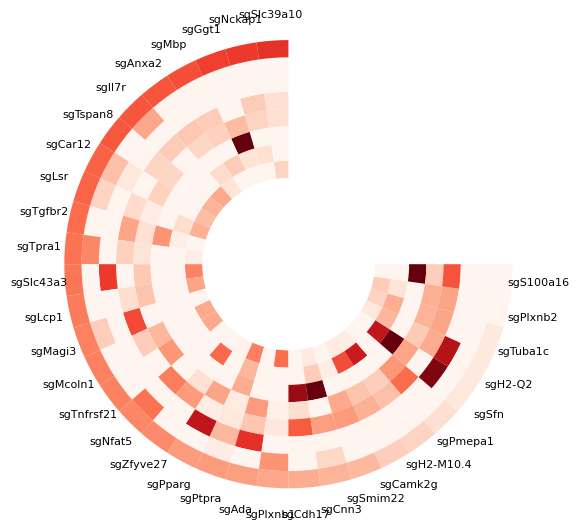

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), subplot_kw={'projection': 'polar'})

cmap = plt.colormaps['Reds']

order_by = 7

g_df = p_df.loc[~p_df.index.isin(['sgNon-targeting']), :]
# sorted_guides = g_df.index[np.argsort(g_df.loc[list(common_genes), order_by].values)[::-1]].tolist() +\
    # g_df.loc[list(set1 - common_genes), :].index[np.argsort(g_df.loc[list(set1 - common_genes), order_by].values)[::-1]].tolist() +\
    # g_df.loc[list(set2 - common_genes), :].index[np.argsort(g_df.loc[list(set2 - common_genes), order_by].values)[::-1]].tolist()
sorted_guides = g_df.index[np.argsort(g_df.loc[list(common_genes), order_by].values)[::-1]]

# from sklearn.cluster import KMeans

# g_df.replace([-np.inf], -10, inplace=True)
# kmeans = KMeans(n_clusters=10, random_state=0).fit(g_df.values)
# g_df['cluster'] = kmeans.labels_

# sorted_guides = g_df.sort_values('cluster').index.tolist()

mean_val = np.mean(g_df.loc[sorted_guides, :].values)

radius = 0.5
width = 0.1

angle = 1.5 * np.pi / len(sorted_guides)
angles = np.linspace(0.5 * np.pi + angle / 2, 2 * np.pi + angle / 2, len(sorted_guides), endpoint=False)
for cluster in ['None'] * 0 + list(g_df.columns):
    if cluster != 'None':
        guide_colors = cmap((g_df.loc[sorted_guides, cluster].values) * 1 + 0.2)
        bars = ax.bar(x=angles, height=width, width=angle, color=guide_colors, edgecolor='none', bottom=radius, alpha=1)
    else: bars = ax.bar(x=angles, height=width, width=angle, color='none', edgecolor='none', bottom=radius)
    radius = radius + width

ax.spines['polar'].set_visible(False)  # 去除边框
ax.set_xticks(angles, sorted_guides, rotation=0, ha='center', fontsize=8)
# ax.set_xticks([])
# ax.set_yticks(list(np.linspace(6 * width, 18 * width, 12)))
ax.set_yticks([])
ax.grid(False)  # 去除grid线

# plt.xlim([0.5 * np.pi, 2 * np.pi])
# plt.ylim([0, 1])
plt.rcParams['pdf.fonttype']=42
plt.rcParams['font.family'] = 'Arial'
plt.savefig("./plots/cluster_guide_proportion_radar.pdf", format="pdf", bbox_inches='tight')
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

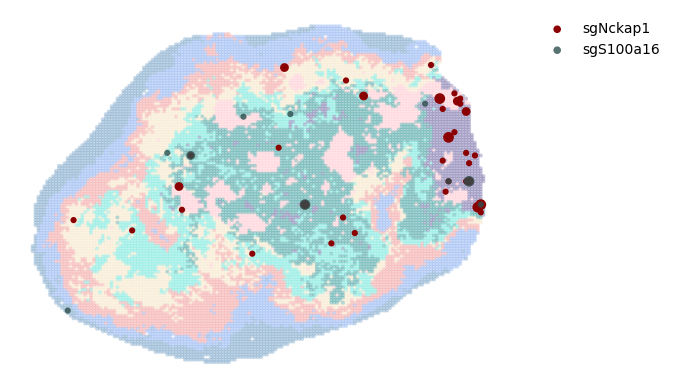

In [56]:
palette = ['turquoise', 'lightcoral', 'steelblue', 'darkslateblue', 'teal', 'cornflowerblue', 'wheat', 'lightpink']
sns.scatterplot(x=cluster_data.obsm['spatial'][:, 0], y=cluster_data.obsm['spatial'][:, 1], s=8,
                hue=cluster_data.obs.cluster, palette=palette, alpha=0.3, legend=False, edgecolor='none')
guide = 'sgNckap1'
sns.scatterplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
                s=guide_data[:, guide].X.toarray().flatten() * 20, color='darkred', alpha=1, legend=True,
                edgecolor='none', label='sgNckap1')
guide = 'sgS100a16'
sns.scatterplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
                s=guide_data[:, guide].X.toarray().flatten() * 20, color='darkslategray', alpha=0.8, legend=True,
                edgecolor='none', label='sgS100a16')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False, labelspacing=0.5)
plt.gca().invert_yaxis()
plt.title('')
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)
plt.show()

In [113]:
gene = 'sgNckap1'

g_data = cluster_data[(guide_data[:, gene].X > 0)].copy()
ntc_data = cluster_data[(guide_data[:, 'sgNon-targeting'].X > 0)].copy()

import anndata as ad
g_data.obs['guide'] = gene
ntc_data.obs['guide'] = 'Control'
cdata = ad.concat([g_data, ntc_data])

sc.pp.normalize_total(cdata, target_sum=1e4)
sc.pp.log1p(cdata)

sc.tl.rank_genes_groups(cdata, groupby='guide', method='wilcoxon')

pval_cutoff = 1
top_n = 10000

result = cdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
# top_genes_df.to_csv('./deg.csv', index=None, sep='\t')
top_genes_df

Gene  Log2FoldChange      padj     score   Cluster
0    Il31ra        0.394932  0.023929  4.767836   Control
1      Cdk8        0.289749  0.076185  4.347567   Control
2   Filip1l        0.604820  0.076185  4.291009   Control
3     Rack1        0.145985  0.106260  4.104368   Control
4      Actb        0.167542  0.106260  4.075654   Control
5     H2-K1        0.191863  0.106260  4.056946   Control
6    Camk1d        0.345182  0.106260  4.021271   Control
7     Atp5j       -1.083620  0.972879 -3.396958   Control
8     Cox7b       -1.224413  0.454213 -3.630586   Control
9     Cox7b        1.224413  0.454213  3.630586  sgNckap1
10    Atp5j        1.083620  0.972879  3.396958  sgNckap1
11   Camk1d       -0.345182  0.106260 -4.021271  sgNckap1
12    H2-K1       -0.191863  0.106260 -4.056946  sgNckap1
13     Actb       -0.167542  0.106260 -4.075654  sgNckap1
14    Rack1       -0.145985  0.106260 -4.104368  sgNckap1
15  Filip1l       -0.604820  0.076185 -4.291009  sgNckap1
16     Cdk8       -0.289749  0.076185 -4.347567  sgNckap1
17   Il31ra       -0.394932  0.023929 -4.767836  sgNckap1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family '

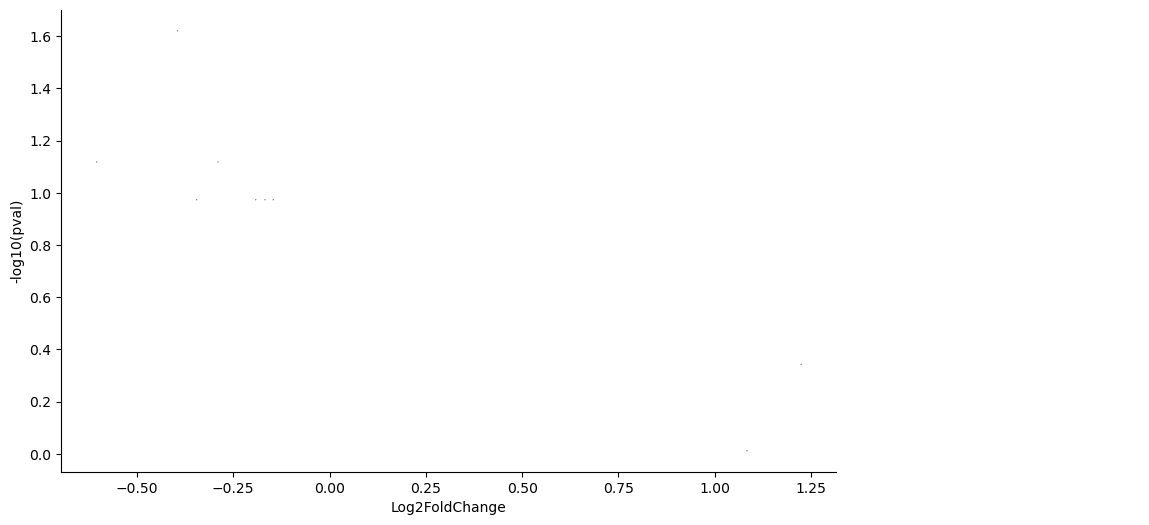

In [114]:
pval_cutoff = 1

plot_df = top_genes_df[top_genes_df.Cluster == 'sgNckap1']
plot_df['-log10(pval)'] = -np.log10(plot_df.padj)

plot_df['sig'] = ['Up' if l2fc > 0 and p_value < 0.01 else ('Down' if l2fc < 0 and p_value < 0.01 else 'Not Significant')
                  for p_value, l2fc in zip(plot_df.padj, plot_df.Log2FoldChange)]
plot_df['size'] = [1 if sig == 'Up' else (2 if sig == 'Down' else 0) for sig in plot_df.sig]

plot_df = plot_df[(plot_df['-log10(pval)'] < 15) & (plot_df['Log2FoldChange'] > -5) & (plot_df['Log2FoldChange'] < 5)]

plt.figure(figsize=(10, 6))
sns.scatterplot(y='-log10(pval)', x='Log2FoldChange', data=plot_df[plot_df.sig == 'Not Significant'], s=1, legend=True, color='gray', edgecolor='none')
sns.scatterplot(y='-log10(pval)', x='Log2FoldChange', data=plot_df[plot_df.sig != 'Not Significant'], s=4, hue='sig', legend=True, palette=['red', 'blue'], edgecolor='none')

# 标注出sig为Up或Down的gene名
from adjustText import adjust_text

texts = []
for i in range(len(plot_df)):
    if plot_df['sig'].iloc[i] in ['Down'] and (plot_df['-log10(pval)'].iloc[i] > 4 or plot_df['Log2FoldChange'].iloc[i] < -2) or plot_df['sig'].iloc[i] in ['Up']:
        gene_name = plot_df['Gene'].iloc[i]
        color = 'blue' if gene_name == 'Spp1' else 'black'
        texts.append(plt.text(plot_df['Log2FoldChange'].iloc[i], 
                               plot_df['-log10(pval)'].iloc[i], 
                               gene_name, 
                               fontsize=8, 
                               color=color))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', linewidth=0.1))
# plt.hlines(y=2, xmin=-5, xmax=5, color='black', linestyle='--', alpha=0.5, linewidth=0.5)
plt.legend(title='', loc='right', bbox_to_anchor=(1.4, 0.5), frameon=False, labelspacing=0.5)

# plt.xlim([-5, 5])
# plt.ylim([-0.2, 15])
sns.despine()
plt.show()

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

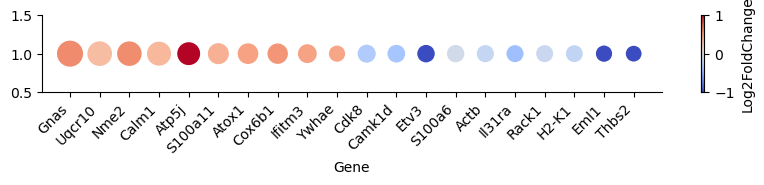

In [104]:
plot_nck_df = top_genes_df[top_genes_df.Cluster == 'sgNckap1']
plot_nck_df['-log10(pval)'] = -np.log10(plot_nck_df.padj)

# 过滤数据
plot_nck_df = plot_nck_df[(plot_nck_df['-log10(pval)'] < 15) & (plot_nck_df['Log2FoldChange'] > -5) & (plot_nck_df['Log2FoldChange'] < 5)]
up_df = plot_nck_df[plot_nck_df.Log2FoldChange > 0].sort_values(by='-log10(pval)', ascending=False).head(10)
down_df = plot_nck_df[plot_nck_df.Log2FoldChange < 0].sort_values(by='-log10(pval)', ascending=False).head(10)

heatmap_df = pd.concat([up_df, down_df])[['Gene', 'Log2FoldChange', '-log10(pval)']].set_index('Gene')
plt.figure(figsize=(10, 1))
scatter = sns.scatterplot(x=heatmap_df.index, y=1, s=heatmap_df['-log10(pval)'] * 40, c=heatmap_df['Log2FoldChange'], cmap='coolwarm', legend=False, vmax=1, vmin=-1)
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.5])
colorbar = plt.colorbar(scatter.collections[0], label='Log2FoldChange')  # 添加colorbar
# colorbar.ax.set_aspect(10)  # 修改colorbar的长宽比
# colorbar.set_ticks([-5, 0, 5])  # 修改colorbar ticks
sns.despine()
plt.show()

In [105]:
gene = 'sgS100a16'

g_data = cluster_data[(guide_data[:, gene].X > 0)].copy()
ntc_data = cluster_data[(guide_data[:, 'sgNon-targeting'].X > 0)].copy()

import anndata as ad
g_data.obs['guide'] = gene
ntc_data.obs['guide'] = 'Control'
cdata = ad.concat([g_data, ntc_data])

sc.pp.normalize_total(cdata, target_sum=1e4)
sc.pp.log1p(cdata)

sc.tl.rank_genes_groups(cdata, groupby='guide', method='t-test')

pval_cutoff = 1
top_n = 10000

result = cdata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_genes_df = pd.DataFrame()

for group in groups:
    genes = result['names'][group]
    log2fc = result['logfoldchanges'][group]
    padj = result['pvals_adj'][group]
    score = result['scores'][group]
    
    data = pd.DataFrame({
        'Gene': genes,
        'Log2FoldChange': log2fc,
        'padj': padj,
        'score': score,
        'Cluster': group
    })
    
    filtered_data = data[data['padj'] < pval_cutoff]
    sorted_data = filtered_data.sort_values(by='score', ascending=False)
    top_genes = sorted_data.head(top_n)
    top_genes_df = pd.concat([top_genes_df, top_genes], ignore_index=True)

deg = top_genes_df["Gene"].unique().tolist()
# top_genes_df.to_csv('./deg.csv', index=None, sep='\t')
top_genes_df

Gene  Log2FoldChange           padj      score    Cluster
0       Tex264       29.749714  8.674297e-112  25.343992    Control
1      Tmem123       29.578535  6.238858e-105  24.373724    Control
2       Slc4a2       29.615585  1.144897e-104  24.313656    Control
3      Apbb1ip       29.503359  3.270195e-102  23.959974    Control
4         Msh2       29.573786  3.779878e-101  23.800362    Control
...        ...             ...            ...        ...        ...
19995   Scaper      -27.332752   4.505012e-26 -11.087020  sgS100a16
19996   Csf2ra      -27.347282   4.240334e-26 -11.093093  sgS100a16
19997   Trim23      -27.325302   4.240334e-26 -11.093232  sgS100a16
19998    Ptpn3      -27.396917   4.190868e-26 -11.094549  sgS100a16
19999     Iqce      -27.328819   4.115522e-26 -11.096478  sgS100a16

[20000 rows x 5 columns]

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

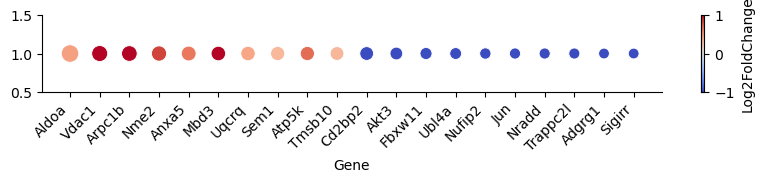

In [108]:
plot_s100_df = top_genes_df[top_genes_df.Cluster == 'sgS100a16']
plot_s100_df['-log10(pval)'] = -np.log10(plot_s100_df.padj)

# 过滤数据
plot_s100_df = plot_s100_df[(plot_s100_df['-log10(pval)'] < 15) & (plot_s100_df['Log2FoldChange'] > -5) & (plot_s100_df['Log2FoldChange'] < 5)]
up_df = plot_s100_df[plot_s100_df.Log2FoldChange > 0].sort_values(by='-log10(pval)', ascending=False).head(10)
down_df = plot_s100_df[plot_s100_df.Log2FoldChange < 0].sort_values(by='-log10(pval)', ascending=False).head(10)

heatmap_df = pd.concat([up_df, down_df])[['Gene', 'Log2FoldChange', '-log10(pval)']].set_index('Gene')
plt.figure(figsize=(10, 1))
scatter = sns.scatterplot(x=heatmap_df.index, y=1, s=heatmap_df['-log10(pval)'] * 40, c=heatmap_df['Log2FoldChange'], cmap='coolwarm', legend=False, vmax=1, vmin=-1)
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.5])
colorbar = plt.colorbar(scatter.collections[0], label='Log2FoldChange')  # 添加colorbar
# colorbar.ax.set_aspect(10)  # 修改colorbar的长宽比
# colorbar.set_ticks([-5, 0, 5])  # 修改colorbar ticks
sns.despine()
plt.show()

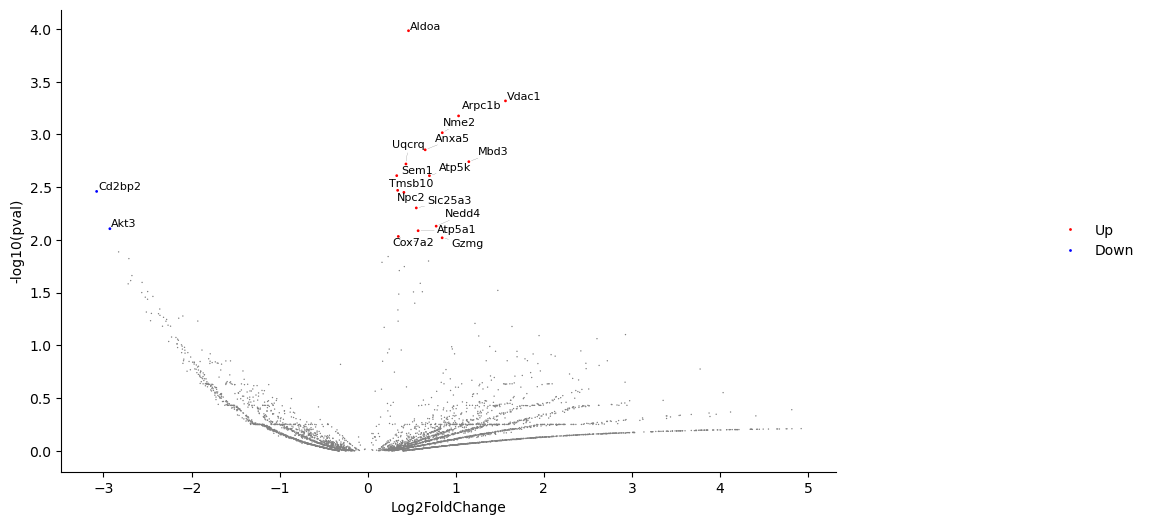

In [206]:
pval_cutoff = 1

plot_df = top_genes_df[top_genes_df.Cluster == 'sgS100a16']
plot_df['-log10(pval)'] = -np.log10(plot_df.padj)

plot_df['sig'] = ['Up' if l2fc > 0 and p_value < 0.01 else ('Down' if l2fc < 0 and p_value < 0.01 else 'Not Significant')
                  for p_value, l2fc in zip(plot_df.padj, plot_df.Log2FoldChange)]
plot_df['size'] = [1 if sig == 'Up' else (2 if sig == 'Down' else 0) for sig in plot_df.sig]

plot_df = plot_df[(plot_df['-log10(pval)'] < 15) & (plot_df['Log2FoldChange'] > -5) & (plot_df['Log2FoldChange'] < 5)]

plt.figure(figsize=(10, 6))
sns.scatterplot(y='-log10(pval)', x='Log2FoldChange', data=plot_df[plot_df.sig == 'Not Significant'], s=1, legend=True, color='gray', edgecolor='none')
sns.scatterplot(y='-log10(pval)', x='Log2FoldChange', data=plot_df[plot_df.sig != 'Not Significant'], s=4, hue='sig', legend=True, palette=['red', 'blue'], edgecolor='none')

# 标注出sig为Up或Down的gene名
from adjustText import adjust_text

texts = []
for i in range(len(plot_df)):
    if plot_df['sig'].iloc[i] in ['Down'] and (plot_df['-log10(pval)'].iloc[i] > 4 or plot_df['Log2FoldChange'].iloc[i] < -2) or plot_df['sig'].iloc[i] in ['Up']:
        gene_name = plot_df['Gene'].iloc[i]
        color = 'blue' if gene_name == 'Spp1' else 'black'
        texts.append(plt.text(plot_df['Log2FoldChange'].iloc[i], 
                               plot_df['-log10(pval)'].iloc[i], 
                               gene_name, 
                               fontsize=8, 
                               color=color))

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='black', linewidth=0.1))
# plt.hlines(y=2, xmin=-5, xmax=5, color='black', linestyle='--', alpha=0.5, linewidth=0.5)
plt.legend(title='', loc='right', bbox_to_anchor=(1.4, 0.5), frameon=False, labelspacing=0.5)

# plt.xlim([-5, 5])
# plt.ylim([-0.2, 15])
sns.despine()
plt.show()

In [208]:
gene_list = pd.DataFrame({
    'cnt': guide_data[:, pd.concat([entro_df, chi_df], axis=1).head(40).index].X.sum(axis=0),
    'gene': pd.concat([entro_df, chi_df], axis=1).head(40).index,
    'rank': np.arange(40)
}).gene.tolist()
for gene in gene_list:
    print(gene.lstrip('sg'))

H2-Q6
Id1
Grb7
Tnfrsf10b
Irf1
Sytl2
Rnf149
Clstn1
Rhoc
Myof
Jun
Itgb1
H13
Mcoln1
Liph
Pla2g2a
Tmem161a
S100a14
Ano6
Gdf15
Mfap3
Pak1
Sfn
Cavin1
Pip5k1a
Adap1
Tjp2
Clu
S100a16
Dstn
Slc39a14
Gpa33
Cnn3
Magi3
Plxnb1
Ggt1
Slc38a7
Il7r
Tnfrsf21
H2-M10.4


# Consistency Analysis


In [85]:
guide_data.var_names[guide_data.var_names.str.startswith('sgCa')]

Index(['sgCacybp', 'sgCamk2d', 'sgCamk2g', 'sgCamk2n1', 'sgCant1', 'sgCanx',
       'sgCapn2', 'sgCar12', 'sgCav1', 'sgCavin1'],
      dtype='object')

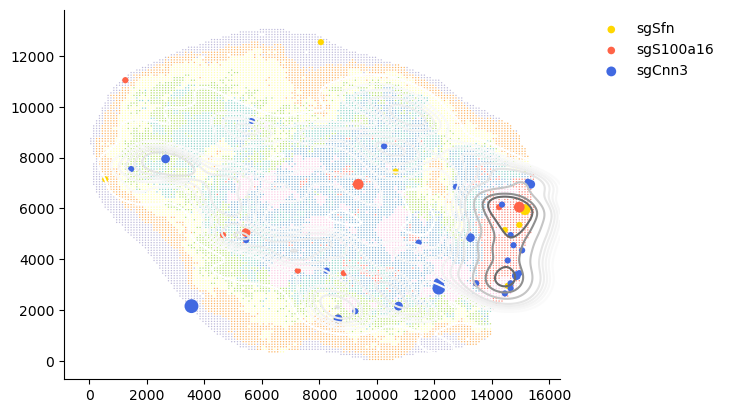

In [107]:
sfn_size = guide_data[:, 'sgSfn'].X.flatten()
s100_size = guide_data[:, 'sgS100a16'].X.flatten()
cnn3_size = guide_data[:, 'sgCnn3'].X.flatten()
ntc_size = guide_data[:, 'sgNon-targeting'].X.flatten()
cant_size = guide_data[:, 'sgCant1'].X.flatten()
sns.kdeplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
            weights=ntc_size, cmap='Greys', alpha=1, bw_adjust=0.4, fill=False, label='sgNon-targeting')
sns.scatterplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
                hue=guide_data.obs.cluster, palette='Set3', edgecolor='none', s=1, legend=False)
sns.scatterplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
                s=sfn_size * 20, c='gold', edgecolor='none', label='sgSfn')
sns.scatterplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
                s=s100_size * 20, c='tomato', edgecolor='none', label='sgS100a16')
sns.scatterplot(x=guide_data.obsm['spatial'][:, 0], y=guide_data.obsm['spatial'][:, 1],
                s=cnn3_size * 20, c='royalblue', edgecolor='none', label='sgCnn3')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
sns.despine()
plt.show()


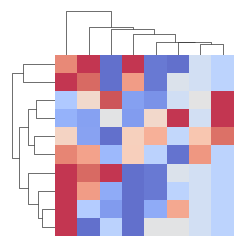

In [277]:
p_df = c_df.div(c_df.sum(axis=0))
p_df = p_df.T - p_df['sgNon-targeting'].T

ax = sns.clustermap(p_df.loc[chi_df.iloc[45:55].index], cmap='coolwarm', vmax=0.05, vmin=-0.05, alpha=0.8, cbar_pos=None, figsize=(3.3, 3))
ax.ax_heatmap.set_xticks([])
ax.ax_heatmap.set_yticks([])
ax.ax_heatmap.set_xlabel('')
ax.ax_heatmap.set_ylabel('')
plt.show()

# PERMANOVA

Permanova performs multi-feature multi-sample analysis at the same time. We utilized PERMANOVA so that we can estimate the different significance of Perturbation cells distributed in each cluster compared to **Non-targeting guide** as control.

We base on the assumption that the bins for each guide that have >0 more readout is reliable. Then we extract quantile for each cluster of the focused guide and control and perform permanova across clusters.

In [ ]:
n_quantiles = 100
quantiles = np.linspace(1/ n_quantiles, 1, n_quantiles)

perturb_data = utils.combine_guide_replicates(guide_data)
c_df = pd.concat([pd.DataFrame(perturb_data.X, columns=perturb_data.var_names, index=perturb_data.obs_names), cluster_data.obs["cluster"]], axis=1)

sample_ids = np.array([[name + str(c) for c in c_df.cluster.unique()] for name in ['guide_', 'control_']]).flatten()
metadata = pd.DataFrame({'group': ['perturb'] * len(c_masks) + ['control'] * len(c_masks)}, index=sample_ids)

/home/wpy/stereoseq/20240802-Tumor/bin/utils.py:88: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [ ]:
def calculate_quantiles(group, quantiles):
    return [np.quantile([0] + list(group[group > 0]), qt) for qt in quantiles]

In [ ]:
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import permanova, DistanceMatrix

p_value = {}
non_targeting_quantiles = np.array(c_df.groupby('cluster')['sgNon-targeting'].apply(lambda group: calculate_quantiles(group, quantiles)).values.tolist())
for guide in tqdm(c_df.columns[:-1]):
    if guide == "sgNon-targeting": continue
    g_df = c_df[[guide, "sgNon-targeting", "cluster"]]

    guide_quantiles = np.array(g_df.groupby('cluster')[guide].apply(lambda group: calculate_quantiles(group, quantiles)).values.tolist())
    test_data = np.vstack([guide_quantiles, non_targeting_quantiles])

    dist_matrix = squareform(pdist(test_data, metric='euclidean'))
    dm = DistanceMatrix(dist_matrix, ids=sample_ids)

    results = permanova(dm, metadata, column='group', permutations=999)
    p_value[guide] = results["p-value"]

100%|██████████| 687/687 [1:17:37<00:00,  6.78s/it]


In [ ]:
p_value

{'sgAbca2': 0.001,
 'sgAbca7': 0.004,
 'sgAbcb1b': 0.002,
 'sgAbcc1': 0.006,
 'sgAbcc10': 0.002,
 'sgAbcc3': 0.001,
 'sgAbcc4': 0.008,
 'sgAbcc5': 0.002,
 'sgAbhd2': 0.008,
 'sgAbi1': 0.01,
 'sgActg1': 0.001,
 'sgActn1': 0.002,
 'sgAcvr1b': 0.005,
 'sgAda': 0.001,
 'sgAdam15': 0.003,
 'sgAdam9': 0.001,
 'sgAdap1': 0.001,
 'sgAdd1': 0.004,
 'sgAdd3': 0.001,
 'sgAdgra3': 0.001,
 'sgAdgre5': 0.012,
 'sgAdgrg1': 0.004,
 'sgAgr2': 0.002,
 'sgAgr3': 0.002,
 'sgAgrn': 0.003,
 'sgAimp1': 0.002,
 'sgAmn': 0.001,
 'sgAnk': 0.002,
 'sgAno6': 0.001,
 'sgAno9': 0.002,
 'sgAntxr2': 0.013,
 'sgAnxa1': 0.017,
 'sgAnxa13': 0.001,
 'sgAnxa2': 0.002,
 'sgAoc1': 0.004,
 'sgAplp2': 0.008,
 'sgApp': 0.002,
 'sgAqp3': 0.002,
 'sgArap1': 0.001,
 'sgAreg': 0.001,
 'sgArf6': 0.002,
 'sgArl4a': 0.003,
 'sgAsph': 0.001,
 'sgAtf3': 0.005,
 'sgAtp11a': 0.001,
 'sgAtp13a1': 0.001,
 'sgAtp13a2': 0.001,
 'sgAtp13a3': 0.006,
 'sgAtp1b3': 0.004,
 'sgAtp2b1': 0.004,
 'sgAtp2c2': 0.003,
 'sgAtp6v0a1': 0.002,
 'sgAtp8b1': 

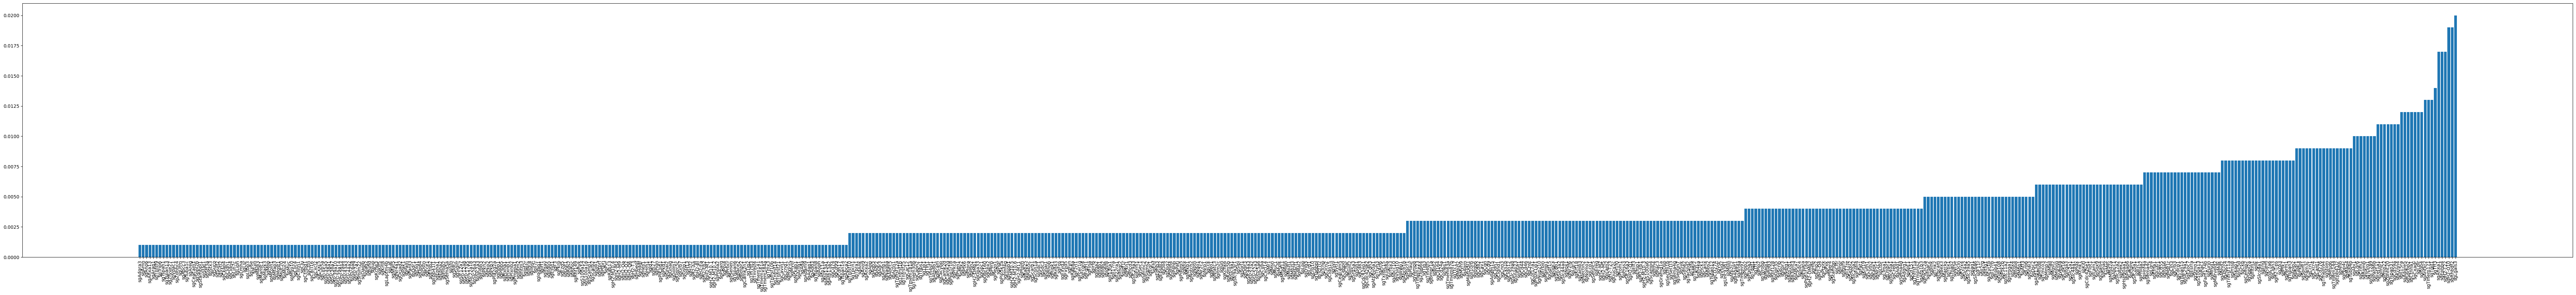

In [ ]:
p_df = pd.DataFrame(p_value.values(), index=p_value.keys(), columns=['p']).sort_values(by='p')
plt.figure(figsize=(100, 10))
plt.bar(p_df[:20].index, p_df[:20].p)
plt.xticks(rotation=90)
plt.show()